<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/experiments/Colleced_Data_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [45]:
# can also load in data as numpy arrays directly 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  test_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'test'), transform=data_transform)
  return test_data

def visualize_image_data(dataset, classes):
  batch = 10
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(10):
      ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  return(images.shape)

def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return raw_train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 1
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        labels = labels+1 # required because mandarin class is class 1 on binary classification model
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
import os
for file_name in os.listdir("/content/drive/My Drive/APS360 Group Project/test_data_melspec_imgs/mandarin/test/"):
    print(file_name)
os.chdir("/content/drive/My Drive/APS360 Group Project/test_data_melspec_imgs/mandarin/test/")
#!ls

brighton_stella1_clip0.jpg
brighton_stella1_clip1.jpg
brighton_stella1_clip3.jpg
brighton_stella1_clip2.jpg
brighton_stella2_clip4.jpg
brighton_stella2_clip6.jpg
brighton_google_doctor1_clip8.jpg
brighton_stella2_clip7.jpg
brighton_stella2_clip5.jpg
DSC_0905_clip9.jpg
DSC_0908_clip13.jpg
DSC_0909_clip10.jpg
DSC_0908_clip11.jpg
DSC_0908_clip12.jpg
DSC_0904_clip14.jpg
DSC_0904_clip16.jpg
DSC_0904_clip15.jpg


17
(10, 3, 128, 192)
128


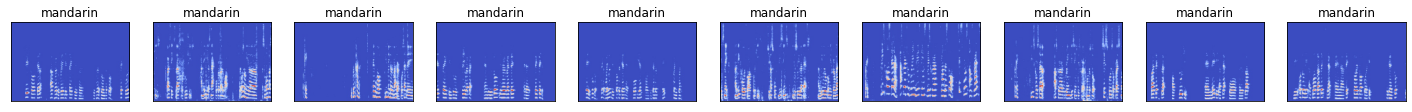

In [37]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/test_data_melspec_imgs/mandarin/"
classes = ['mandarin']

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/test_data_melspec_imgs/mandarin/"

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"
test_data= generate_data_image()
print(len(test_data))
(batch_size, dummy, mfcc_bands, length) = visualize_image_data(test_data, classes)
print(mfcc_bands)

In [39]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

In [44]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 100
learning_rate = 0.0005
num_workers = 1
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Mandarin_MelSpec_Img",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
net = CRNN2(config)

model_path =  "/content/drive/My Drive/APS360 Group Project/model_checkpoints/model_English_Mandarin_MelSpec_Img_bs27_lr0.0005_epoch63/model_English_Mandarin_MelSpec_Img_bs27_lr0.0005_epoch63"
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)

if torch.cuda.is_available():
  net = net.cuda()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
test_acc = get_accuracy_cnn(net, test_loader)

print("Test accuracy is: " + str(test_acc))

Test accuracy is: 0.9
